# Assess RNA binding re-parameterisation

In this notebook, the reparameterisation of the binding energy translated to equilibrium constant $K_{eq}$ is examined for 1800000 RNA binding energies simulated with `IntaRNA` for 200k circuits.

While `IntaRNA` is a powerful RNA binding simulator, it may not account for RNA binding within the context of a cell. Furthermore, for RNA binding reactions where binding occurs less than half of the time (eg $K_{eq}$ < 1), the simulator does not return a binding energy, which may be zero or positive. For these reasons, experimental data offers a good alternative to map binding energy to binding strength. 

Using relative fluorescence and RNA binding data from paper [Na et al. "Metabolic engineering of Escherichia coli using synthetic small regulatory RNAs" (2013)](https://www.nature.com/articles/nbt.2461#Fig1), a function can be fit that uses relative fluorescence as a proxy for the equilibrium constant $K_{eq}$ , where higher fluorescence means lower $K_{eq}$  (less binding) and where a relative fluorescence of 0.5 is equivalent to $K_{eq} = 1$. 

Several challenges for fitting the data include:
- The experimental sequences are very strong due to complementarity by design
- The hybridisation energy for the experimental RNA sequences was calculated with `UNAFold`, which was made for designing riboswitches and focuses more on secondary structure prediction, while `IntaRNA` more generically predicts interaction sites between RNAs. Nevertheless, from figure S7, the length of the RNA sequences they designed vs. the corresponding binding energy match up roughly with the kind of binding energies that `IntaRNA` would predict.

In [2]:
from functools import partial
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.style.use('seaborn-v0_8')
import numpy as np
import pandas as pd
import jax

os.environ["TF_CPP_MIN_LOG_LOVEL"] = "0"
jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from src.utils.misc.units import per_mol_to_per_molecule, gibbs_K_cal


jax.devices()

2023-03-10 13:23:43.509004: W external/org_tensorflow/tensorflow/compiler/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 12606242816


[CpuDevice(id=0)]

Loading previously generated RNA sequences for which the $\Delta G$ has been simulated:

In [3]:
path_to_stats = 'data/ensemble_generate_circuits/2023_02_24_170946/gather_interaction_stats/circuit_stats.csv'
path_to_stats = os.path.join('..', path_to_stats)

circuit_stats = pd.read_csv(path_to_stats)

In [4]:
cols_energies = [c for c in circuit_stats.columns if 'energies' in c and ('path' not in c)]
cols_eqconstants = [c for c in circuit_stats.columns if 'eqconstants' in c and ('path' not in c)]


From the paper mentioned above, we previously roughly fit a function to the reported RNA binding in Figure 1, as explained in the notebook `explanations/binding_energy.ipynb`. 

In [5]:
def F(E):
    """ The binding energy is in units of kcal/mol """
    F = (1-0.01)/(1+np.exp(-(E/2 + 5))) + 0.01
    return F


def equilibrium_constant_fluorescence(E, initial):
    """ The energy input E is \Delta G in kcal/mol """
    return 1/initial * (1/F(E) - 1)


ka = per_mol_to_per_molecule(1000000)

We will now check how the equilibrium constants compare if given the energies that were simulated for the binding between RNAs in 200k circuits, each with 3 randomly generated RNAs that can inter- or self-bind.

In [6]:
def div_ka(Keq):
    return np.divide(ka, Keq)

dfm = circuit_stats.melt(id_vars=['name', 'num_interacting', 'num_self_interacting'],
                         value_vars=cols_energies, value_name='energies')
dfm.loc[dfm['energies'] == 30, 'energies'] = dfm[dfm['energies'] == 30]['energies'].apply(lambda x: x - 30)
dfm['eqconstants_gibbs'] = dfm['energies'].apply(gibbs_K_cal)
dfm['eqconstants_F'] = dfm['energies'].apply(partial(equilibrium_constant_fluorescence, initial=1))
dfm['kd_rate_gibbs'] = dfm['eqconstants_gibbs'].apply(div_ka)
dfm['kd_rate_F'] = dfm['eqconstants_F'].apply(div_ka)
dfm


,name,num_interacting,num_self_interacting,variable,energies,eqconstants_gibbs,eqconstants_F,kd_rate_gibbs,kd_rate_F
0,toy_mRNA_circuit_0,0,0,energies_0-0,0.00,1.000000,0.006670,0.001510,0.226320
1,toy_mRNA_circuit_100000,0,0,energies_0-0,0.00,1.000000,0.006670,0.001510,0.226320
2,toy_mRNA_circuit_100001,0,0,energies_0-0,0.00,1.000000,0.006670,0.001510,0.226320
3,toy_mRNA_circuit_100002,1,0,energies_0-0,0.00,1.000000,0.006670,0.001510,0.226320
4,toy_mRNA_circuit_100003,0,0,energies_0-0,0.00,1.000000,0.006670,0.001510,0.226320
...,...,...,...,...,...,...,...,...,...
1799995,toy_mRNA_circuit_99999,0,0,energies_2-2,0.00,1.000000,0.006670,0.001510,0.226320
1799996,toy_mRNA_circuit_9999,0,1,energies_2-2,0.00,1.000000,0.006670,0.001510,0.226320
1799997,toy_mRNA_circuit_999,0,1,energies_2-2,0.00,1.000000,0.006670,0.001510,0.226320
1799998,toy_mRNA_circuit_99,0,0,energies_2-2,0.00,1.000000,0.006670,0.001510,0.226320


Text(0.5, 1.0, 'Energy (kcal) from 200k simulated circuits vs. parameterised function')

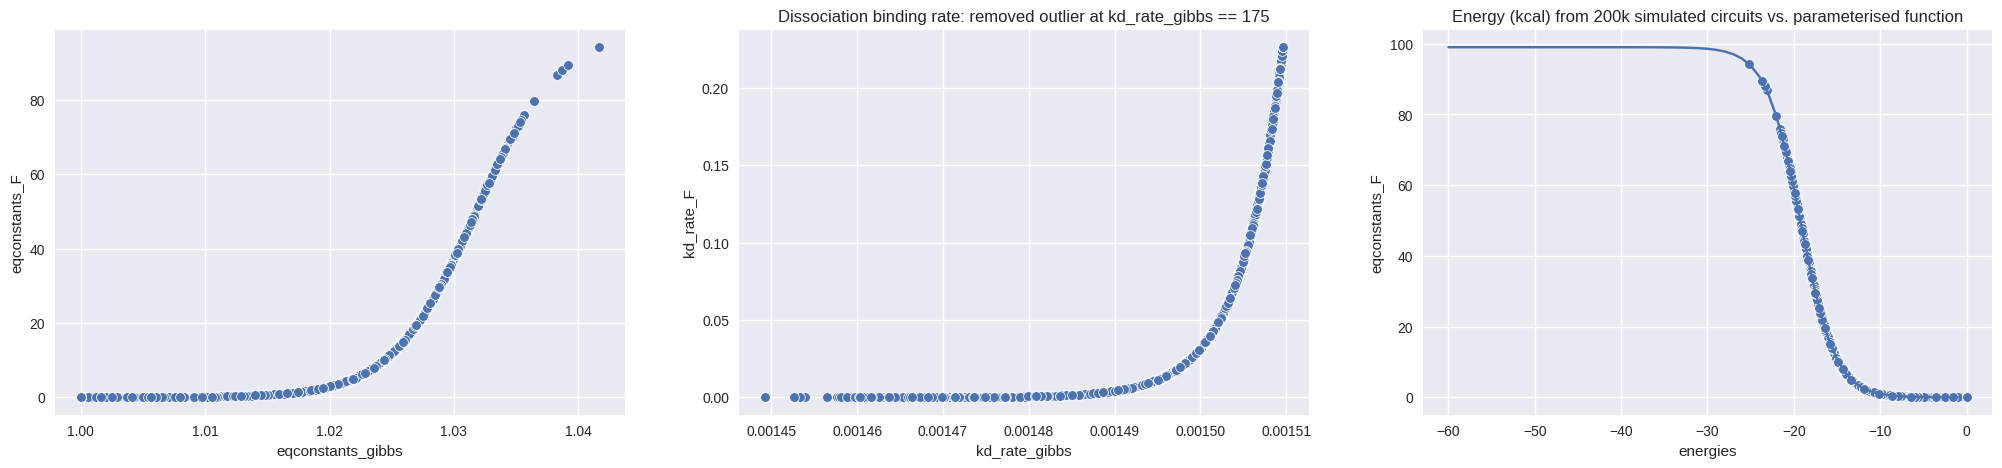

In [7]:
plt.figure(figsize=(25, 5))
ax = plt.subplot(1,3,1)
sns.scatterplot(dfm, x='eqconstants_gibbs', y='eqconstants_F')
ax = plt.subplot(1,3,2)
sns.scatterplot(dfm, x='kd_rate_gibbs', y='kd_rate_F')
plt.title('Dissociation binding rate: removed outlier at kd_rate_gibbs == 175')
ax = plt.subplot(1,3,3)
Erange_from_paper = np.arange(-60, 0)
plt.plot(Erange_from_paper, equilibrium_constant_fluorescence(Erange_from_paper, initial=1))
sns.scatterplot(dfm, x='energies', y='eqconstants_F')
plt.title('Energy (kcal) from 200k simulated circuits vs. parameterised function')

The reparameterised function for the equilibrium constant $K_{eq}$ provides a much more realistic range of binding strengths compared to the output of the Gibbs free energy equation (for calories).

The energy at 0.5 relative binding is -10 kcal


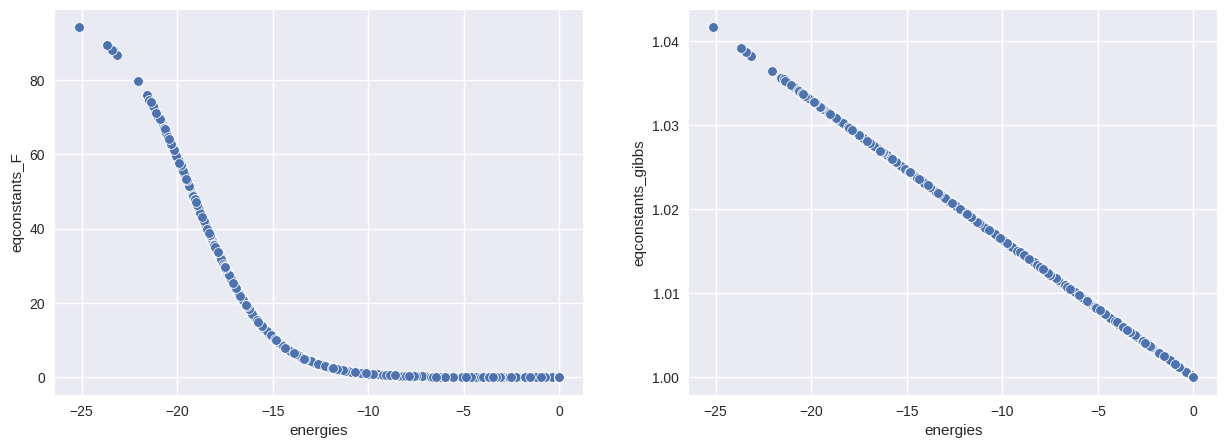

In [9]:
v = equilibrium_constant_fluorescence(np.arange(-70, -50, 0.1), initial=1) 
E_mid = Erange_from_paper[np.argmax(F(Erange_from_paper) >= 0.5)]

plt.figure(figsize=(15, 5))
ax = plt.subplot(1,2,1)
sns.scatterplot(dfm, x='energies', y='eqconstants_F')
ax = plt.subplot(1,2,2)
sns.scatterplot(dfm, x='energies', y='eqconstants_gibbs')

print(f'The energy at 0.5 relative binding is {E_mid} kcal')